# Case study: CPA-catalyzed nucleophilic addition to imines (*Nature* **2019**)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

import sys
sys.path.append('../src/')
import RaRFRegressor
import utils

plt.rcParams['font.size'] = 14
COLORA = '#027F80'
COLORB = '#B2E5FC'


In [2]:
def prepare_dataset(path):

    original_df = pd.read_excel(path, sheet_name='df')
    imines = pd.read_excel(path, sheet_name='imine').set_index('Imine').to_dict(orient='index')
    ligands = pd.read_excel(path, sheet_name='ligand').set_index('ligand').to_dict(orient='index')
    solvents = pd.read_excel(path, sheet_name='solvent').set_index('solvent').to_dict(orient='index')
    nucs = pd.read_excel(path, sheet_name='nuc').set_index('Nucleophile').to_dict(orient='index')

    nuc_descriptors = []
    ligand_descriptors = []
    solvent_descriptors = []
    imine_descriptors = []

    for nuc in original_df['Nucleophile']:
        nuc_descriptors.append(nucs[nuc])

    for ligand in original_df['Ligand']:
        ligand_descriptors.append(ligands[ligand])

    for solvent in original_df['Solvent']:
        solvent_descriptors.append(solvents[solvent])

    for imine in original_df['Imine']:
        imine_descriptors.append(imines[imine])

    descriptors = pd.DataFrame.from_dict(nuc_descriptors).join(pd.DataFrame.from_dict(ligand_descriptors)).join(pd.DataFrame.from_dict(imine_descriptors)).join(pd.DataFrame.from_dict(solvent_descriptors))
    new_df = original_df.join(descriptors)

    return(new_df)

df = prepare_dataset('../data/Nature_2019.xlsx')
reduced_df = VarianceThreshold().fit_transform(df.iloc[:,6:])
df_train, df_test = train_test_split(reduced_df,train_size=0.8, random_state=25)

X_train = df_train[:,1:]
X_test = df_test[:,1:]
y_train = df_train[:,0]
y_test = df_test[:,0]

## RaRF Regression

In [3]:
def run_and_plot(radius, X_train, y_train, X_test, y_test, distances):
    radius_pred, train_neighbours = RaRFRegressor.RaRFRegressor(radius=radius, metric='jaccard').train_parallel(X_train,y_train, include_self='True')
    radius_testpred, test_neighbours, test_neighbours_list = RaRFRegressor.RaRFRegressor(radius=radius,metric='jaccard').predict_parallel(X_train, y_train, X_test, distances)    

    test_neighbours = np.array(test_neighbours)
    nan_indexes = []
    index = -1
    for prediction in radius_testpred:
        index +=1
        if np.isnan(prediction) == True:
            nan_indexes.append(index)
        
    radius_testpred_temp = np.delete(radius_testpred,nan_indexes)
    y_test_temp = np.delete(y_test,nan_indexes)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)


    ax1.plot(y_train,y_train, color='grey', zorder=0)

    train_r2 = r2_score(y_train,radius_pred)
    test_r2 = r2_score(y_test_temp,radius_testpred_temp)
    ax1.scatter(y_train,radius_pred, label='train R2 ' + str(round(train_r2,2)), color='#279383')
    ax1.scatter(y_test_temp,radius_testpred_temp, label='test R2 ' + str(round(test_r2,2)), color='white', edgecolor='#279383')

    ax1.set_xlabel('Measured $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.set_ylabel('Predicted $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.legend()


    ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])
    ax2.legend(['train', 'test'])
    ax2.set_xlim(-10,200)
    ax2.set_xlabel('# of neighbours')

    fig.suptitle(f'Radius {radius}, {len(nan_indexes)}/{len(radius_testpred)} NaNs')
    plt.tight_layout()
    plt.show()

    flattened_list = [item for sublist in test_neighbours_list for item in sublist]

    reaction_set = set(flattened_list)


    return (mean_absolute_error(y_test_temp,radius_testpred_temp)), len(nan_indexes), np.average([test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]), reaction_set, test_r2


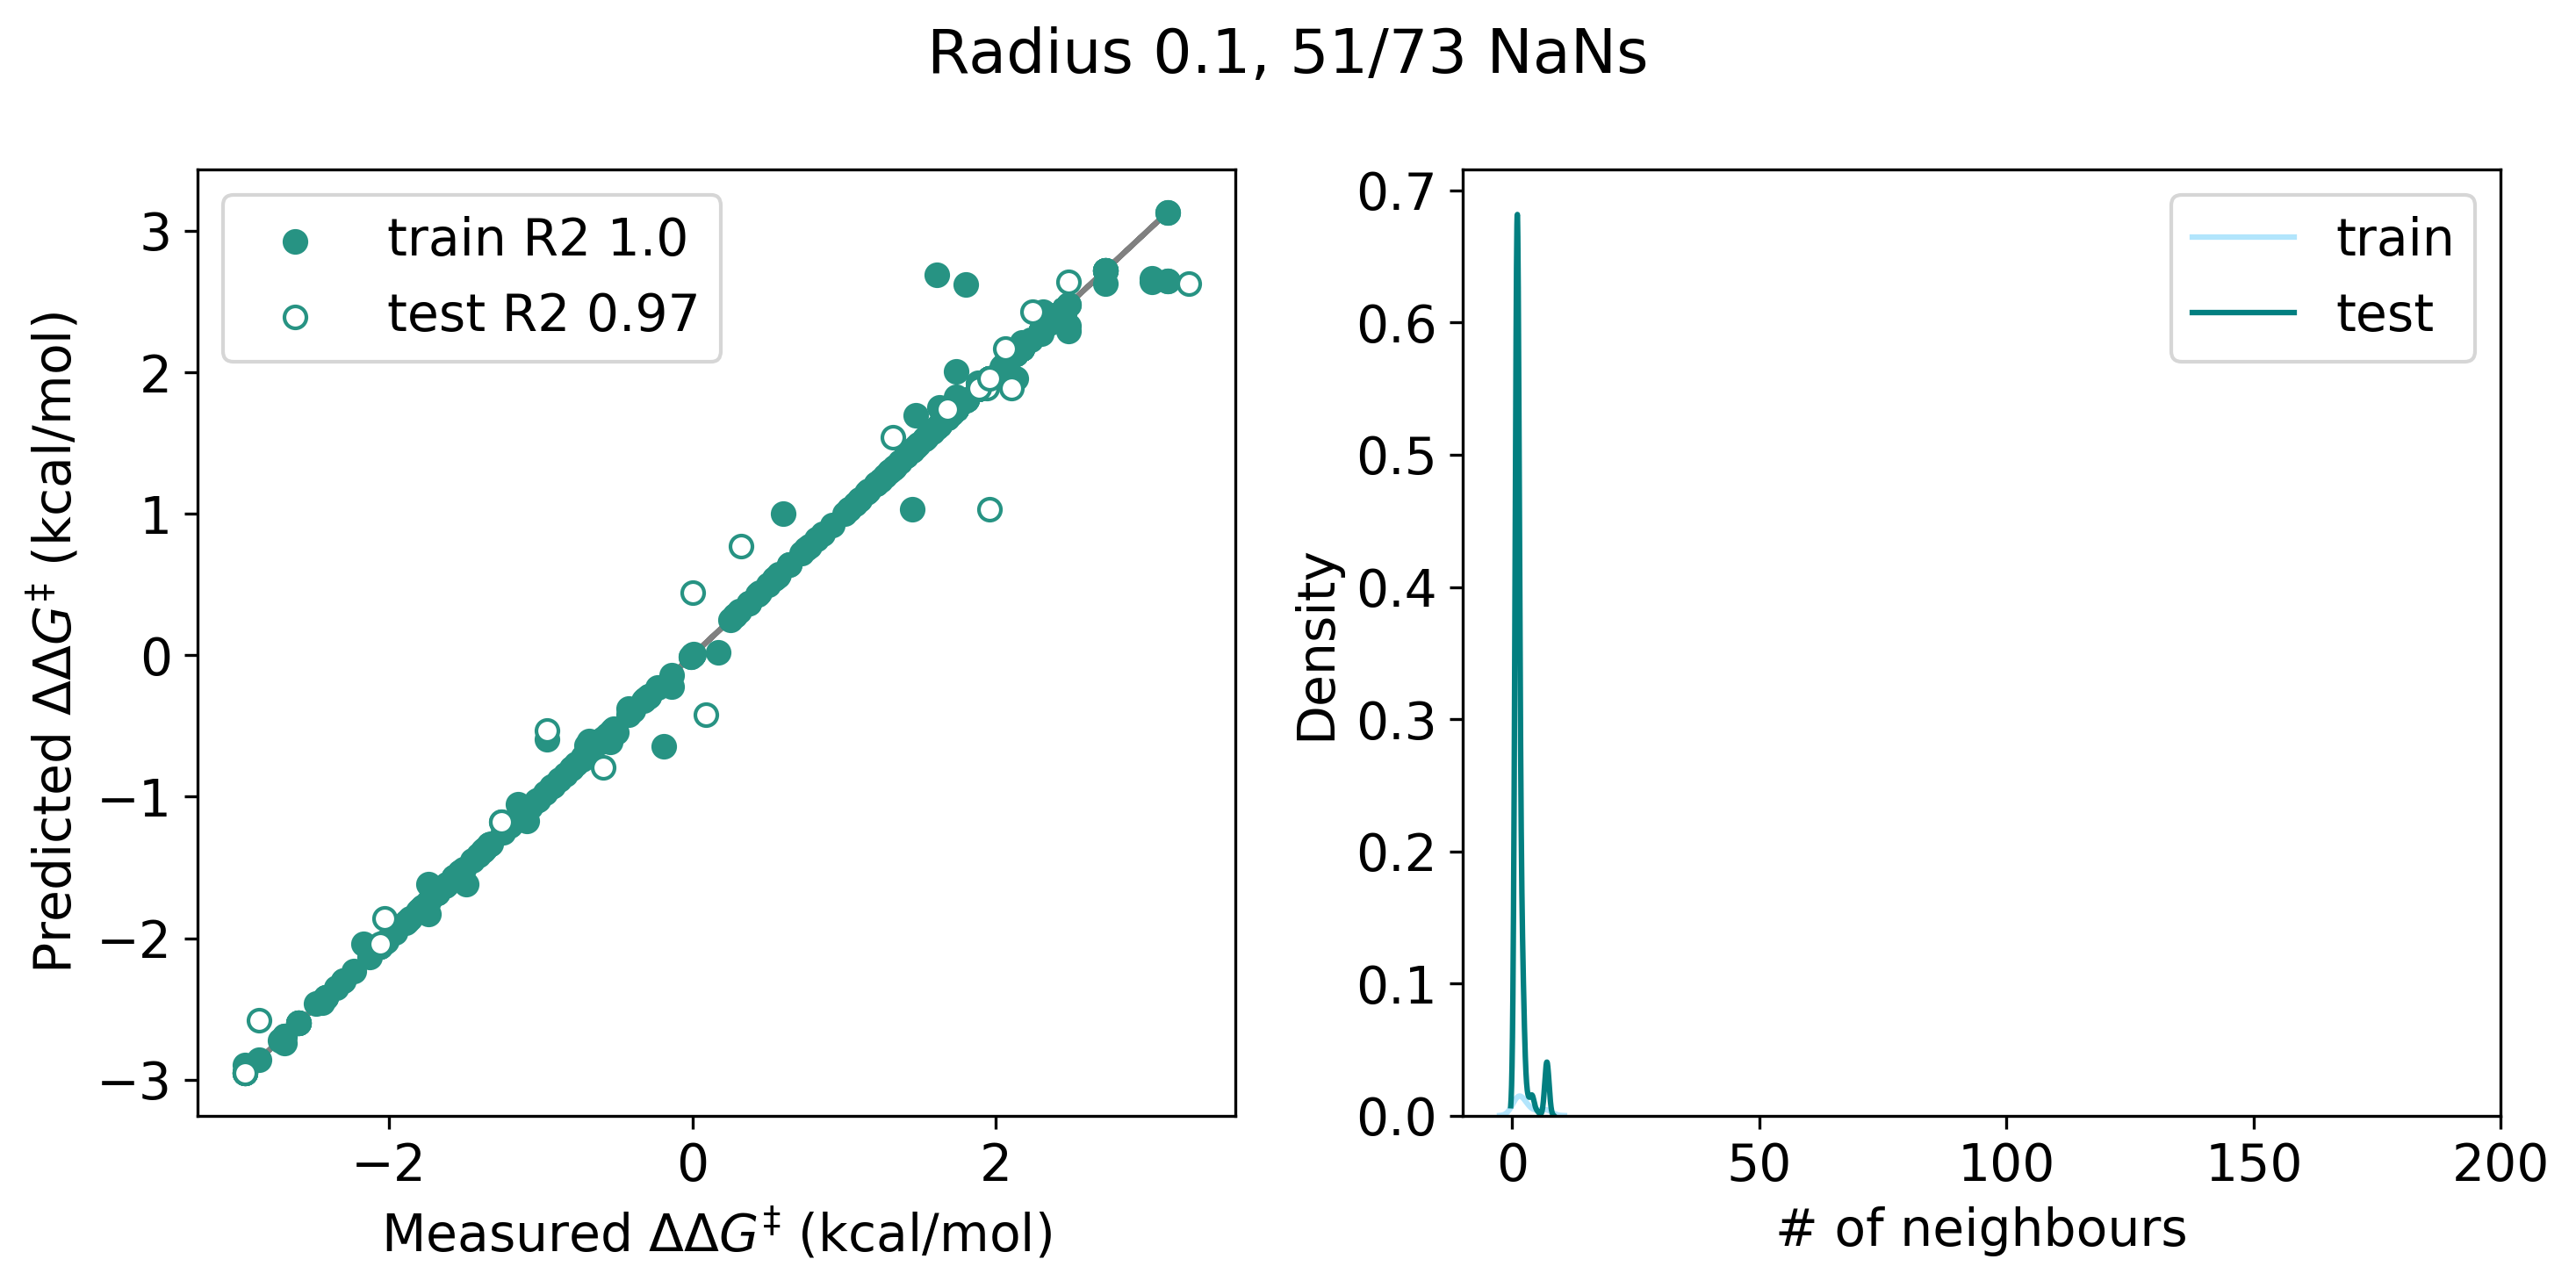

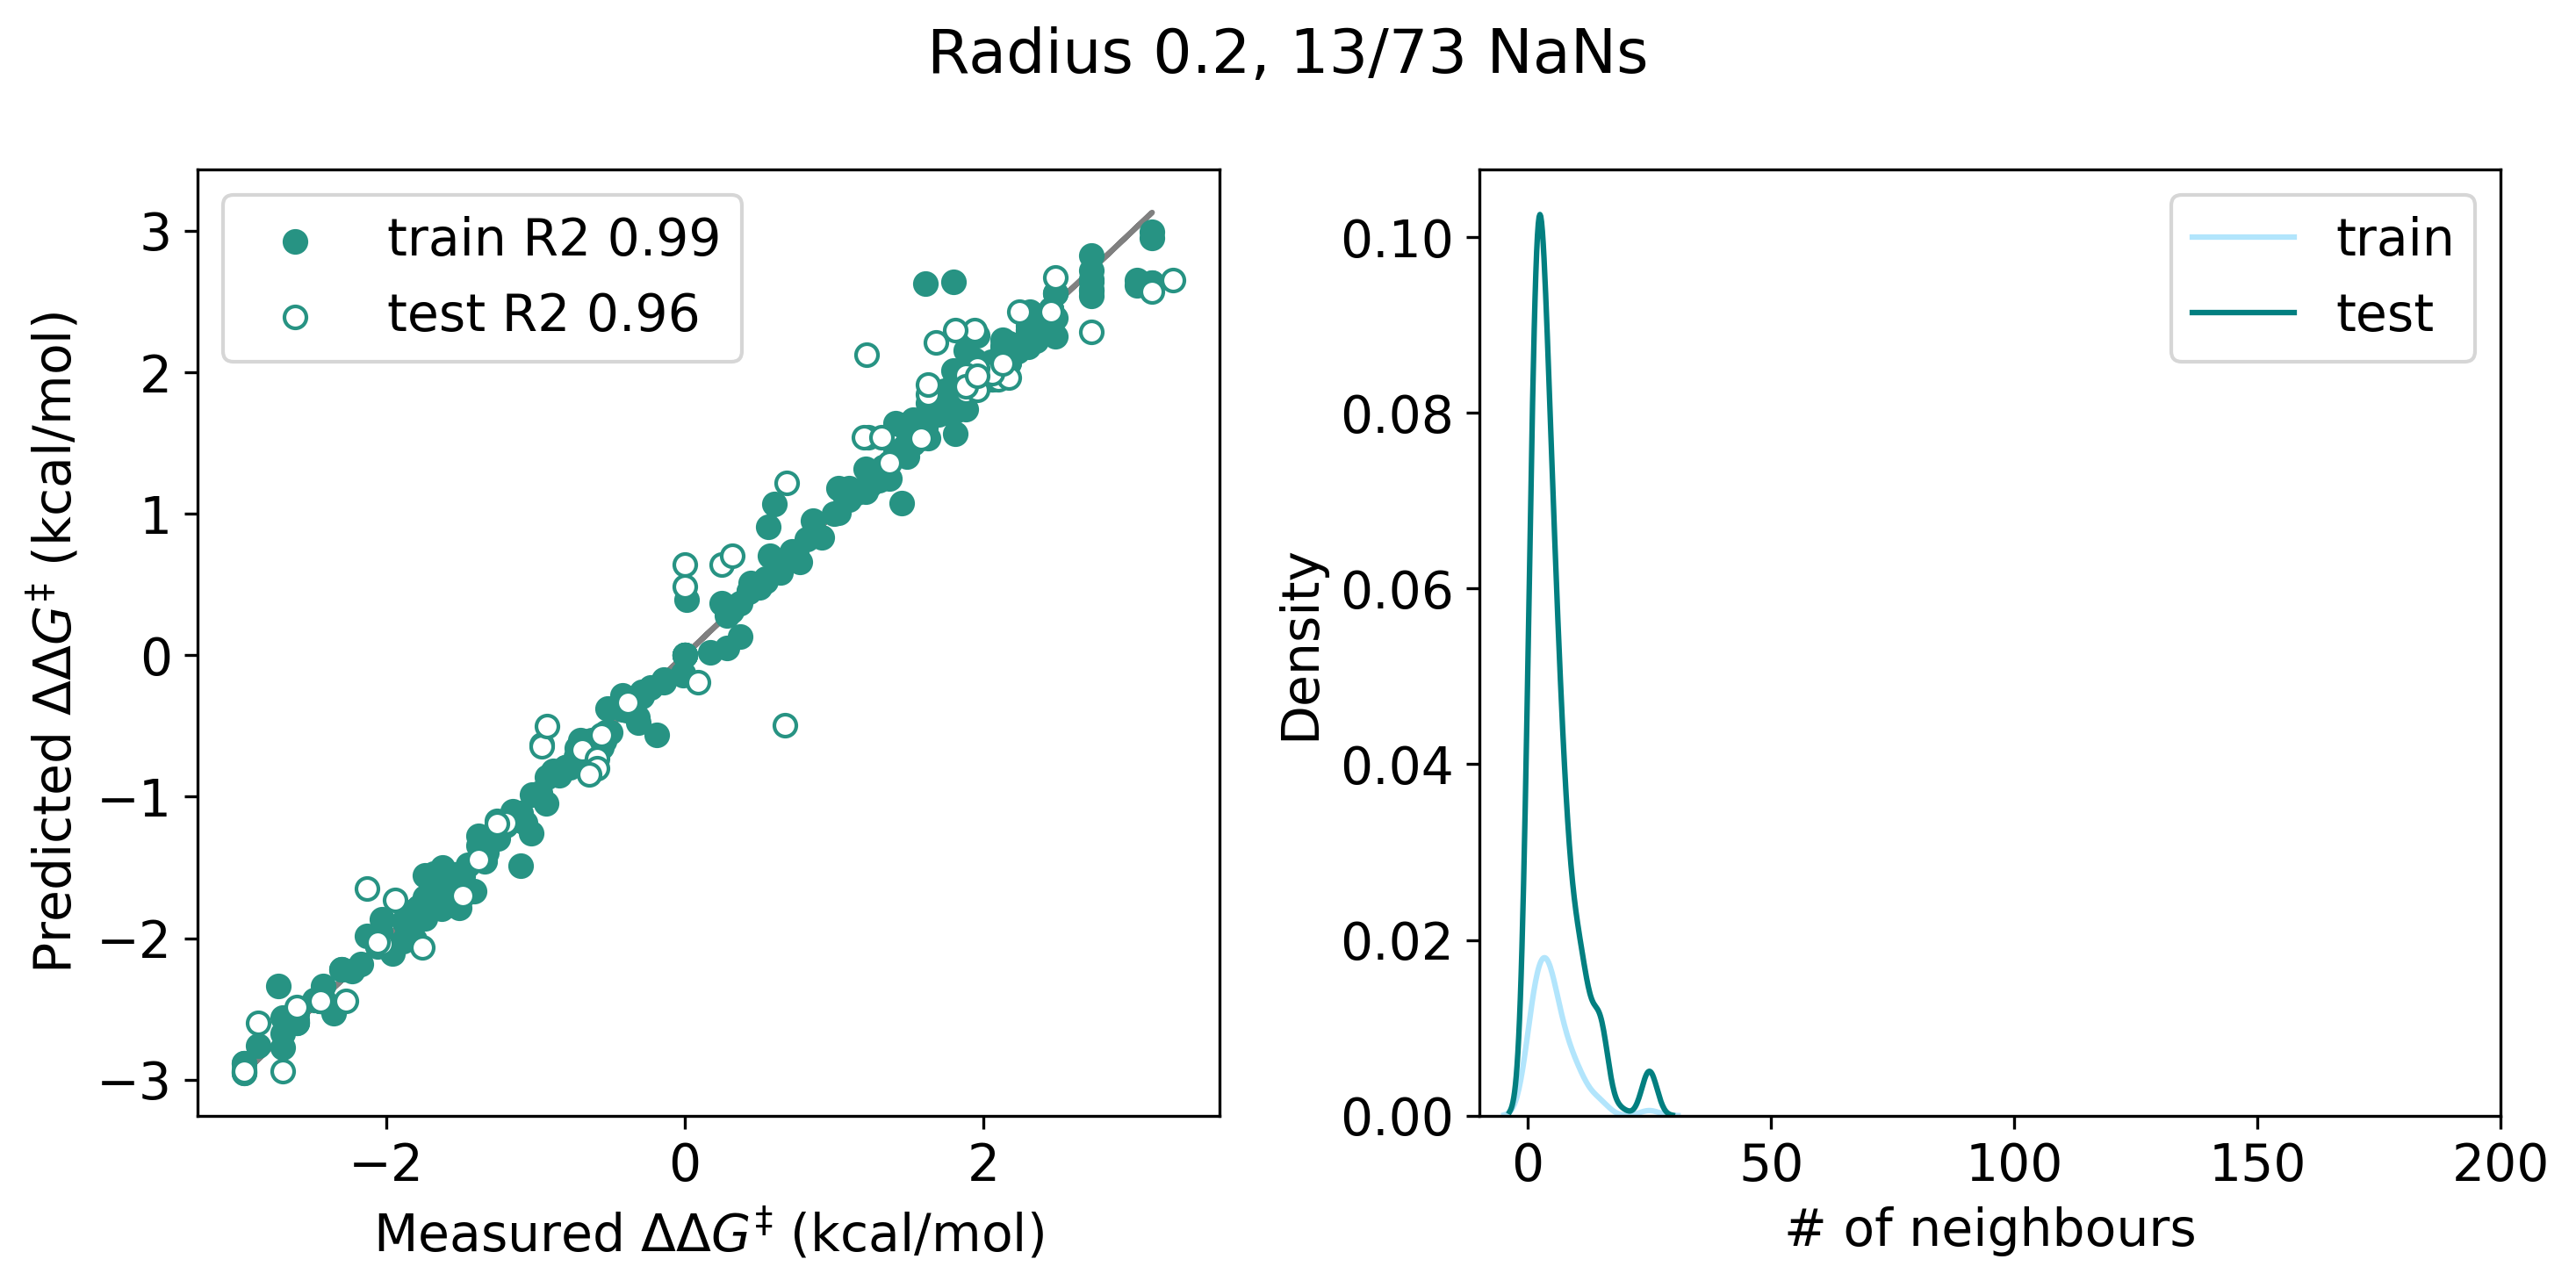

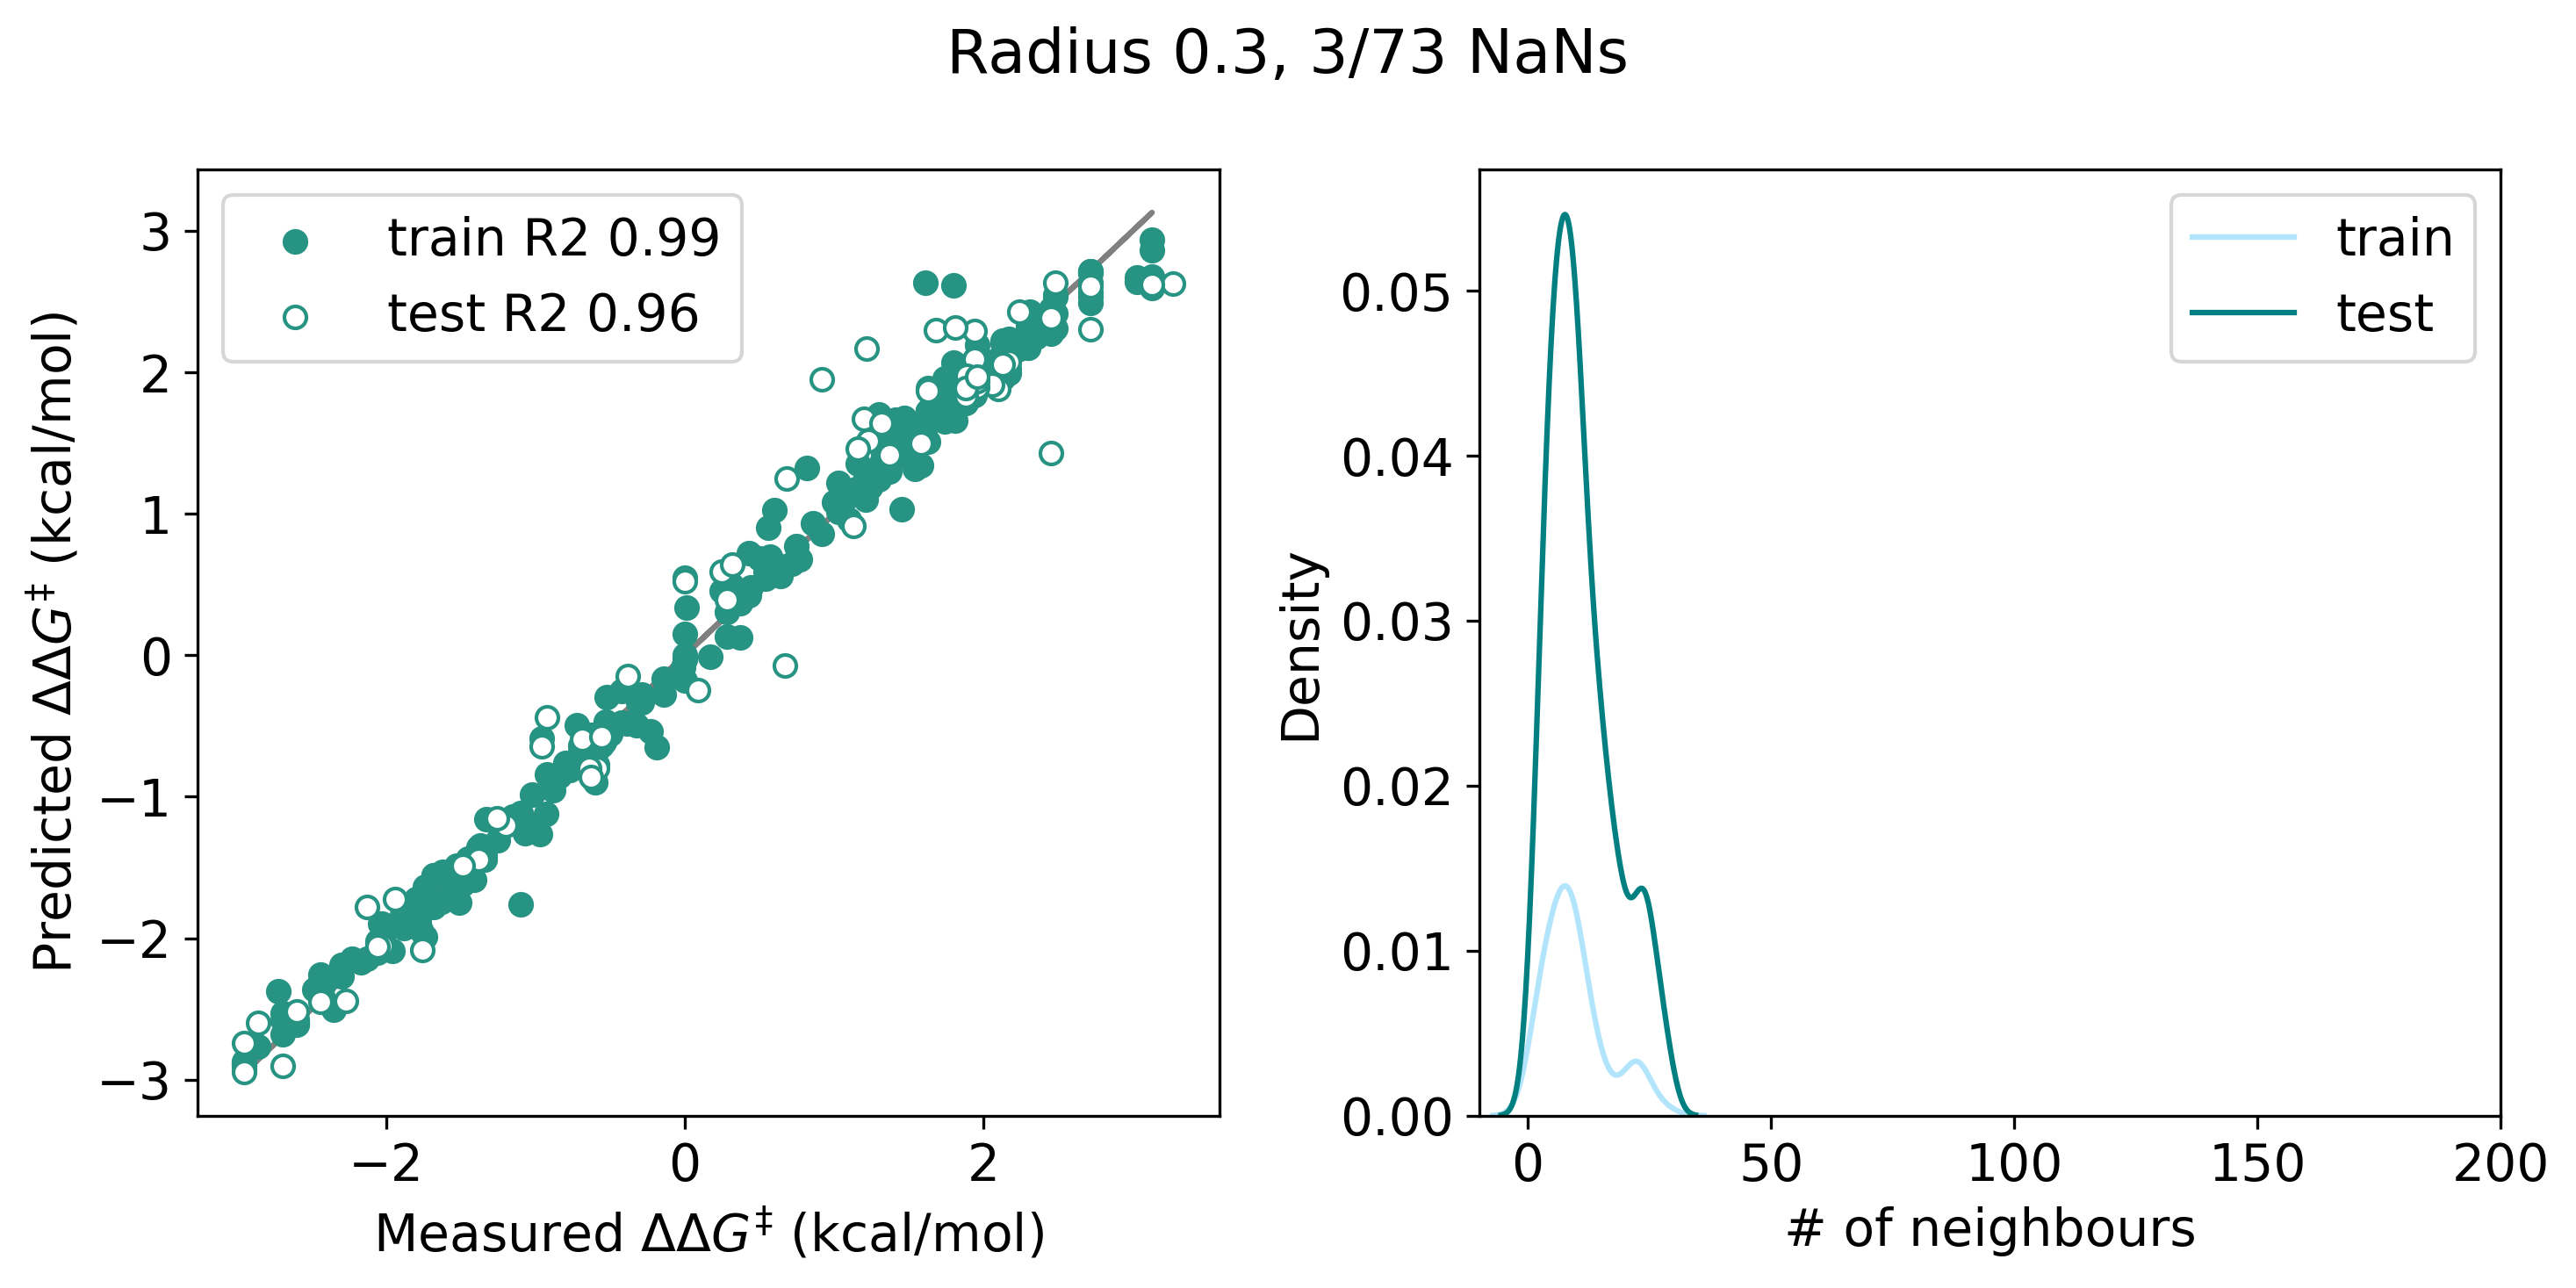

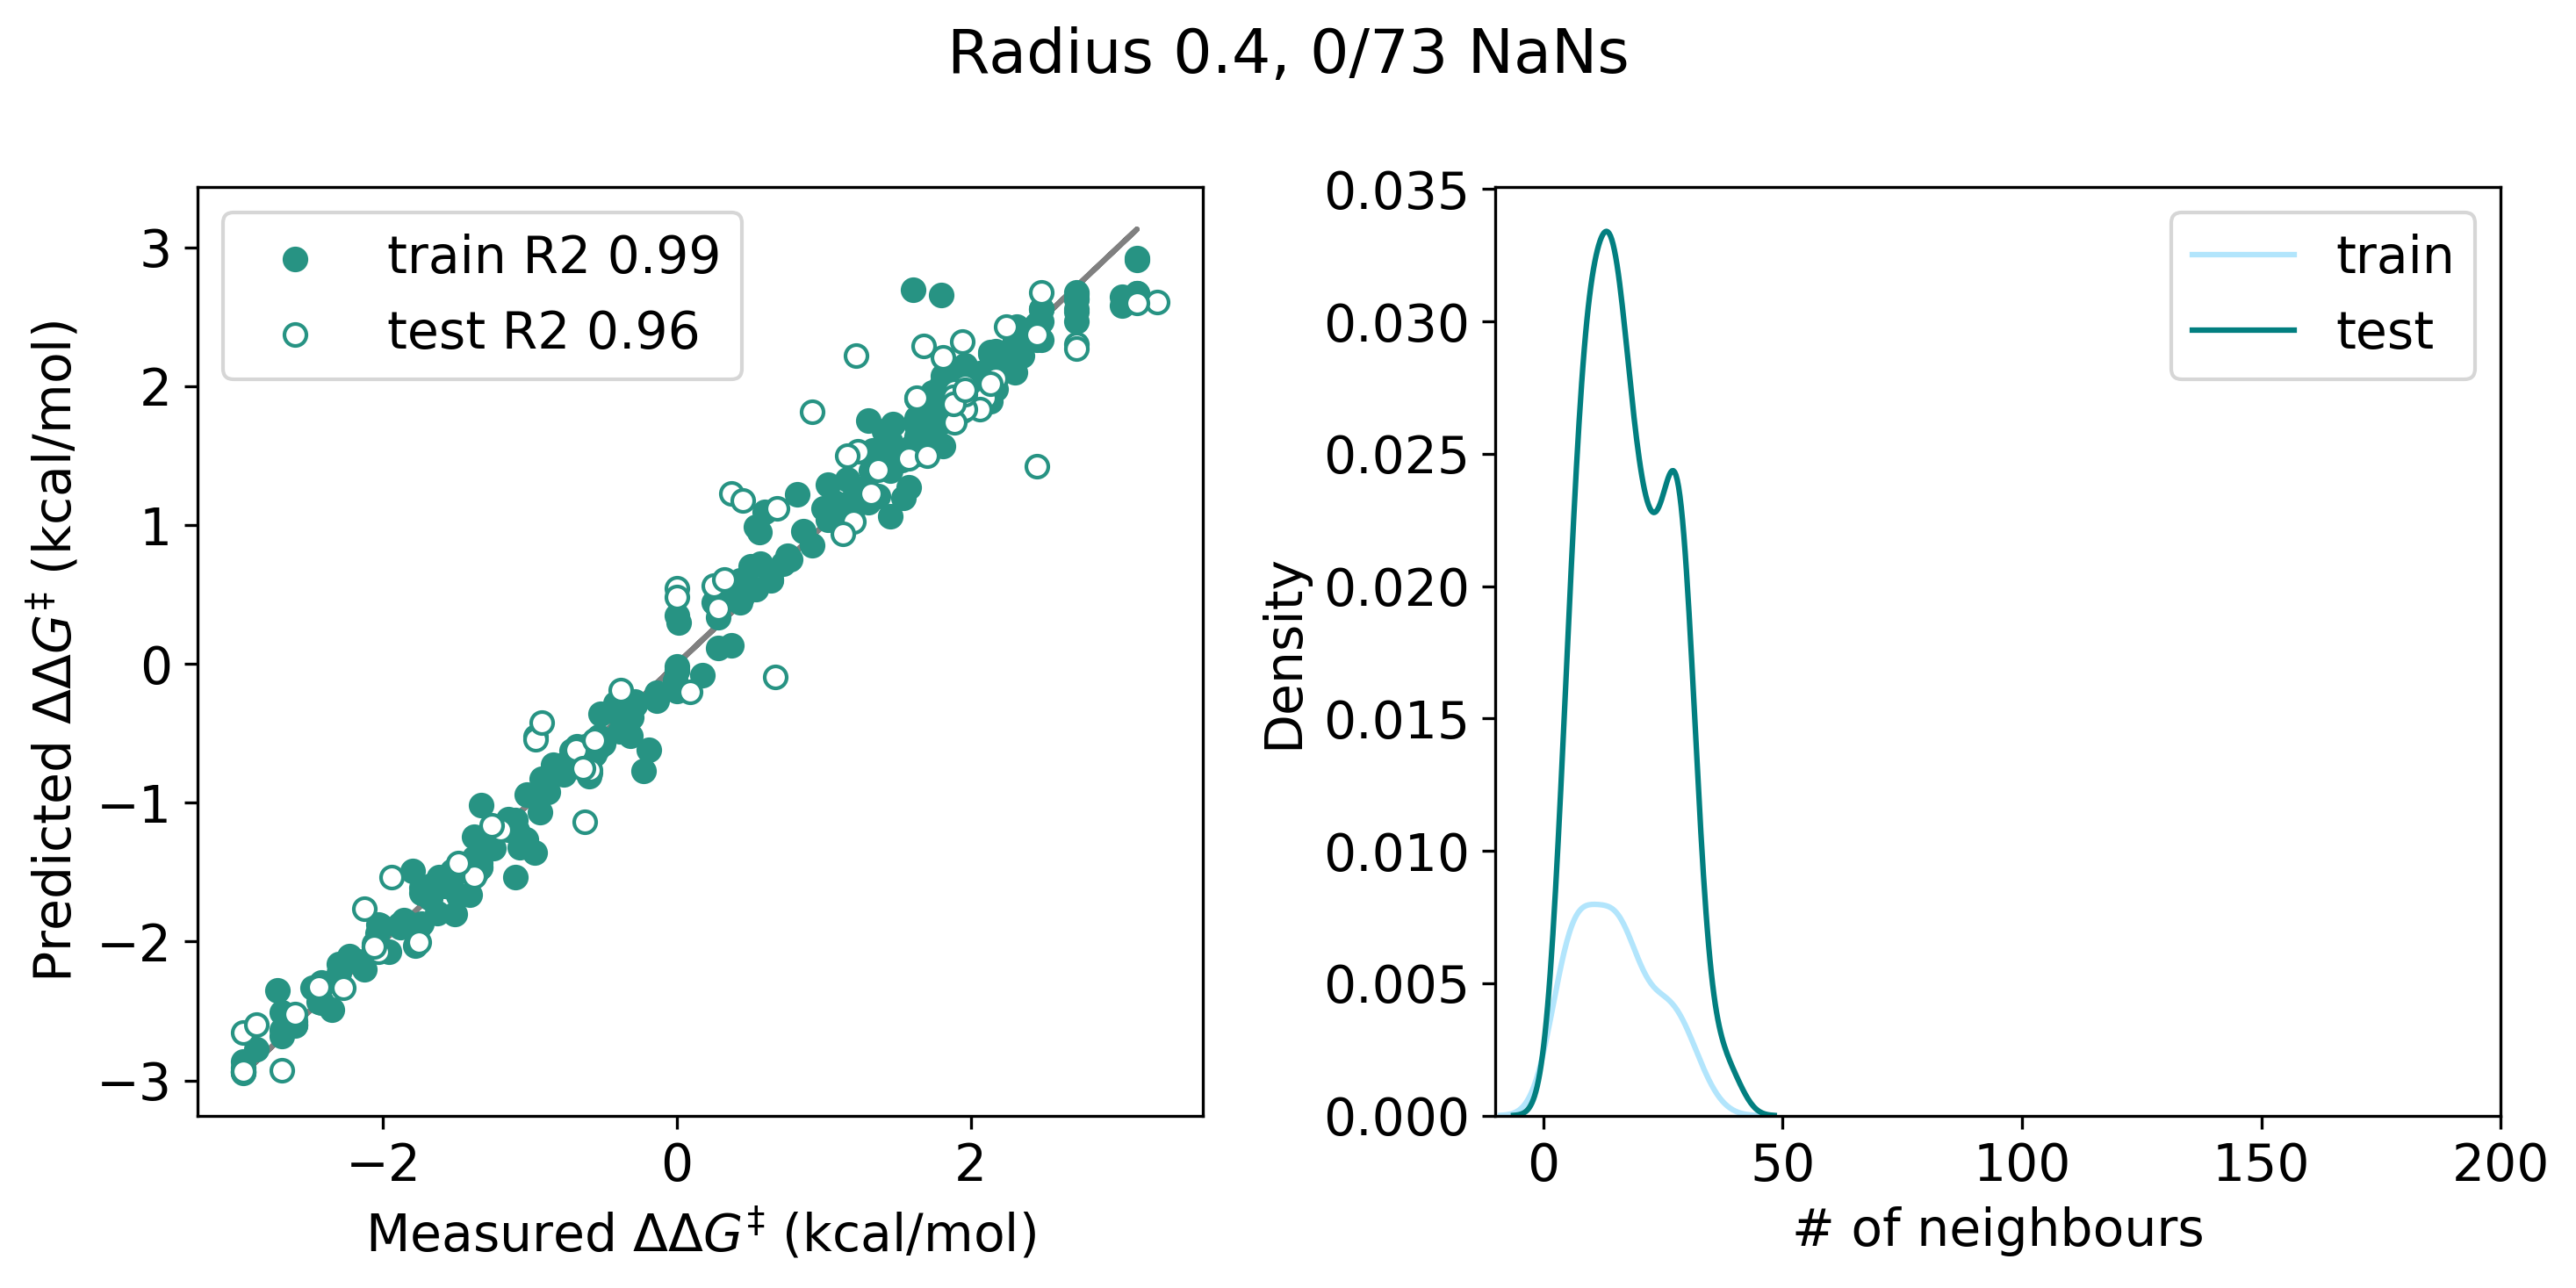

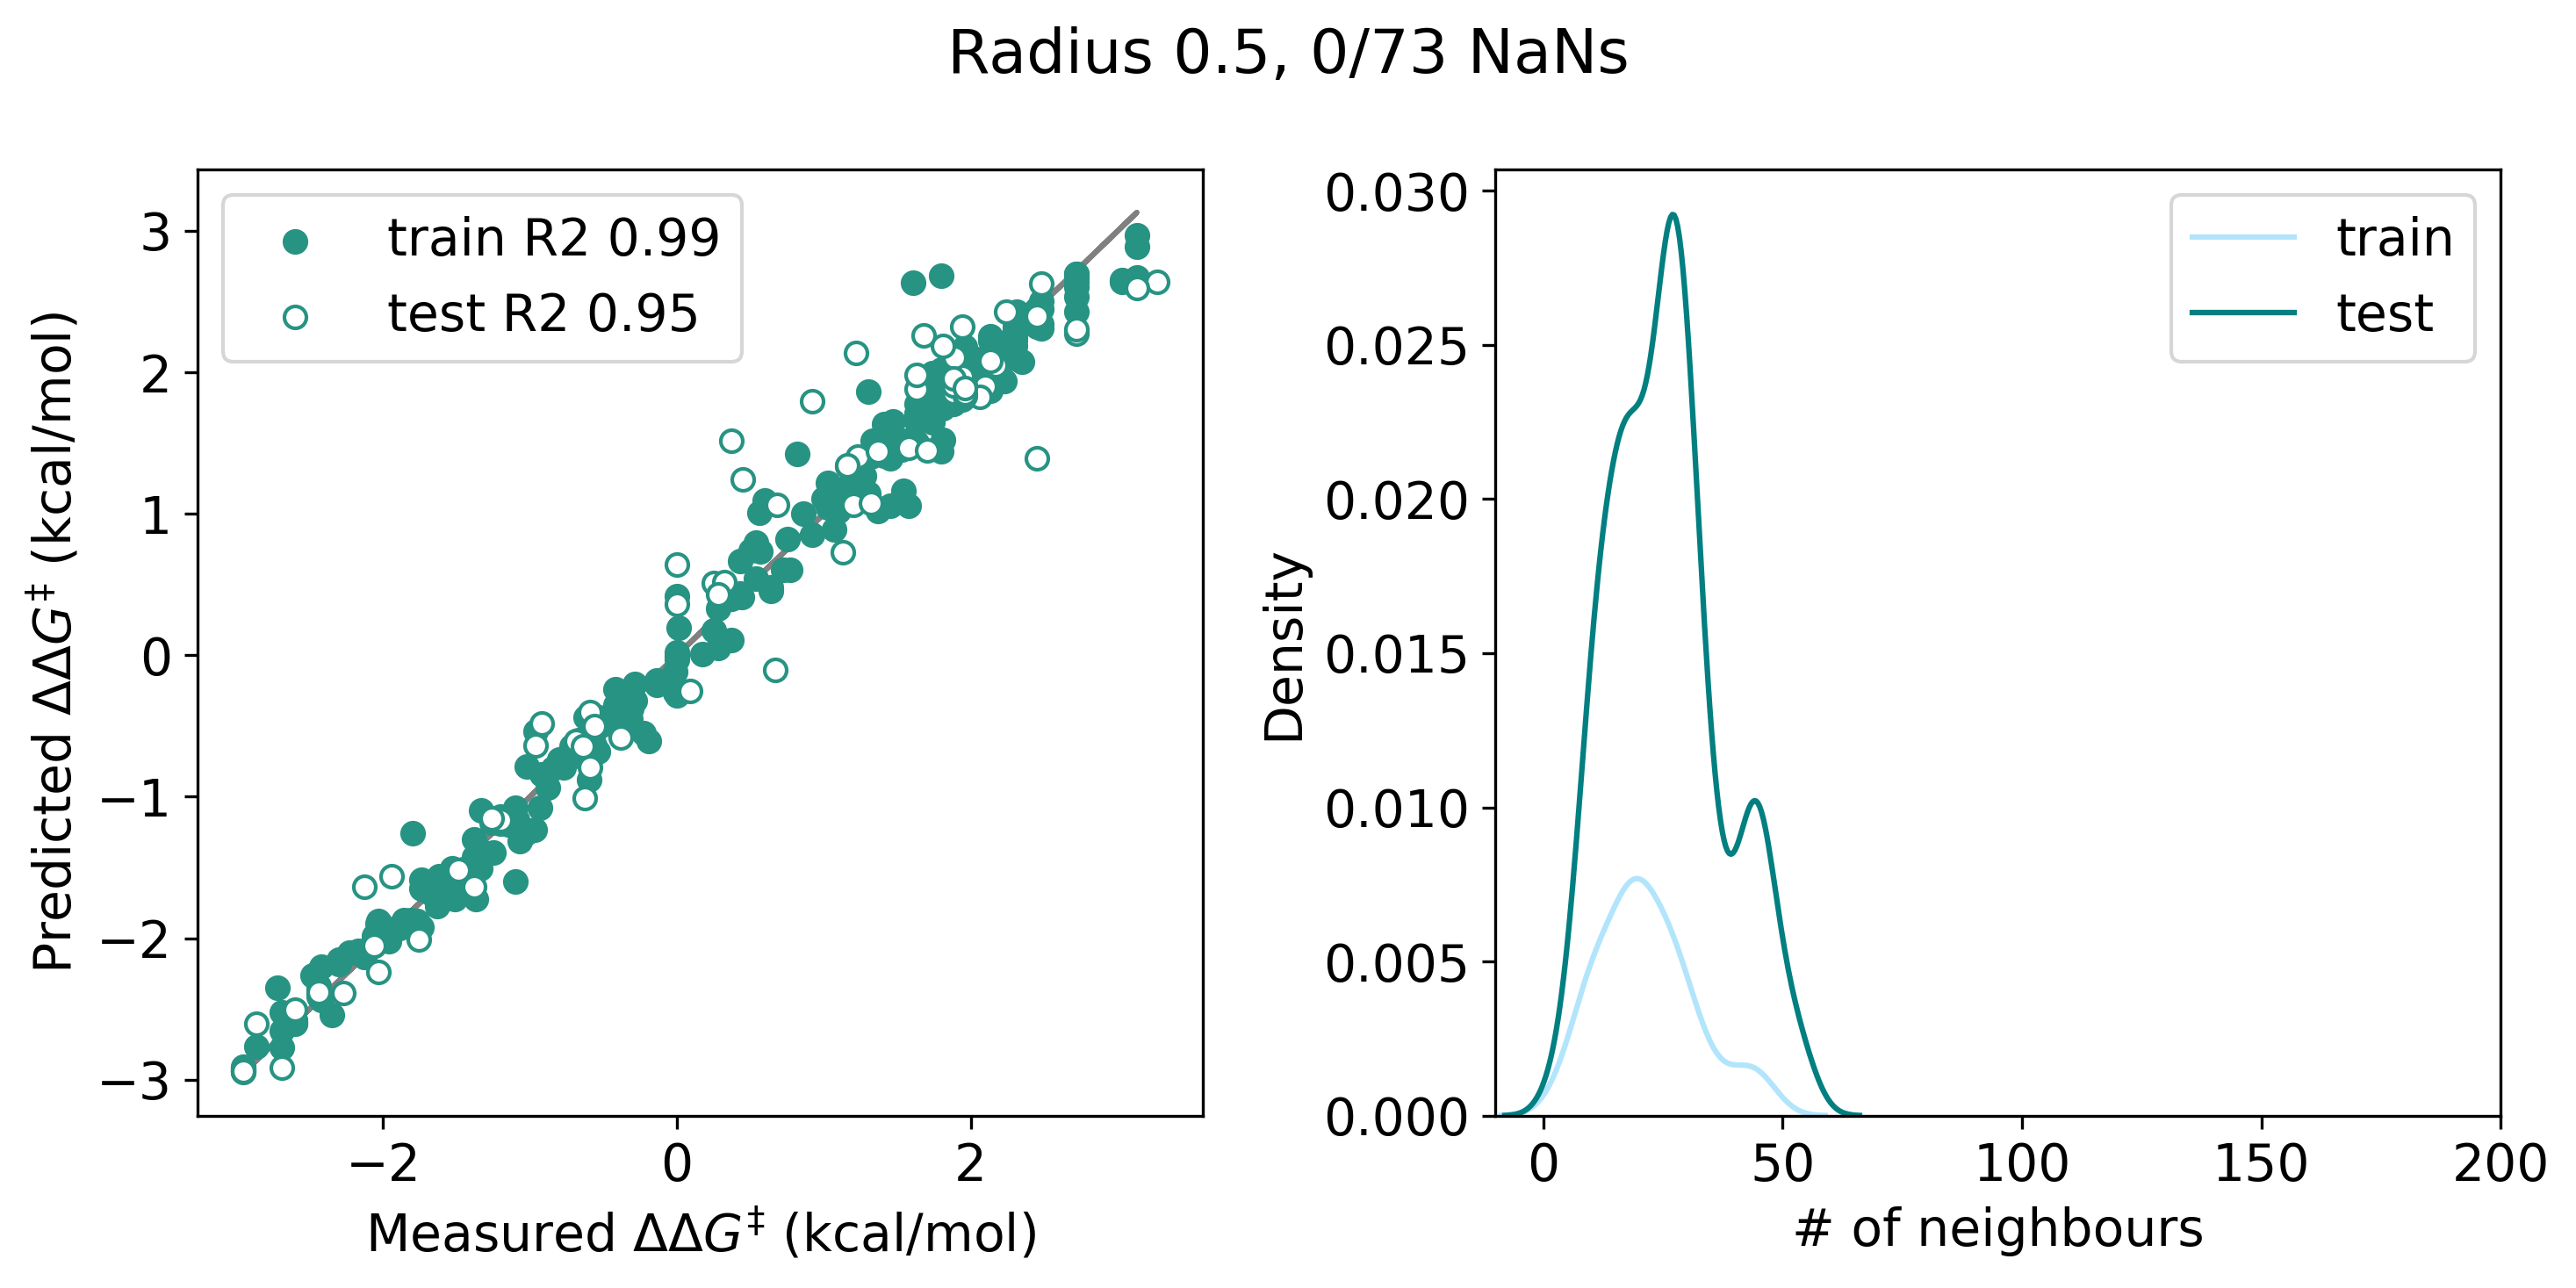

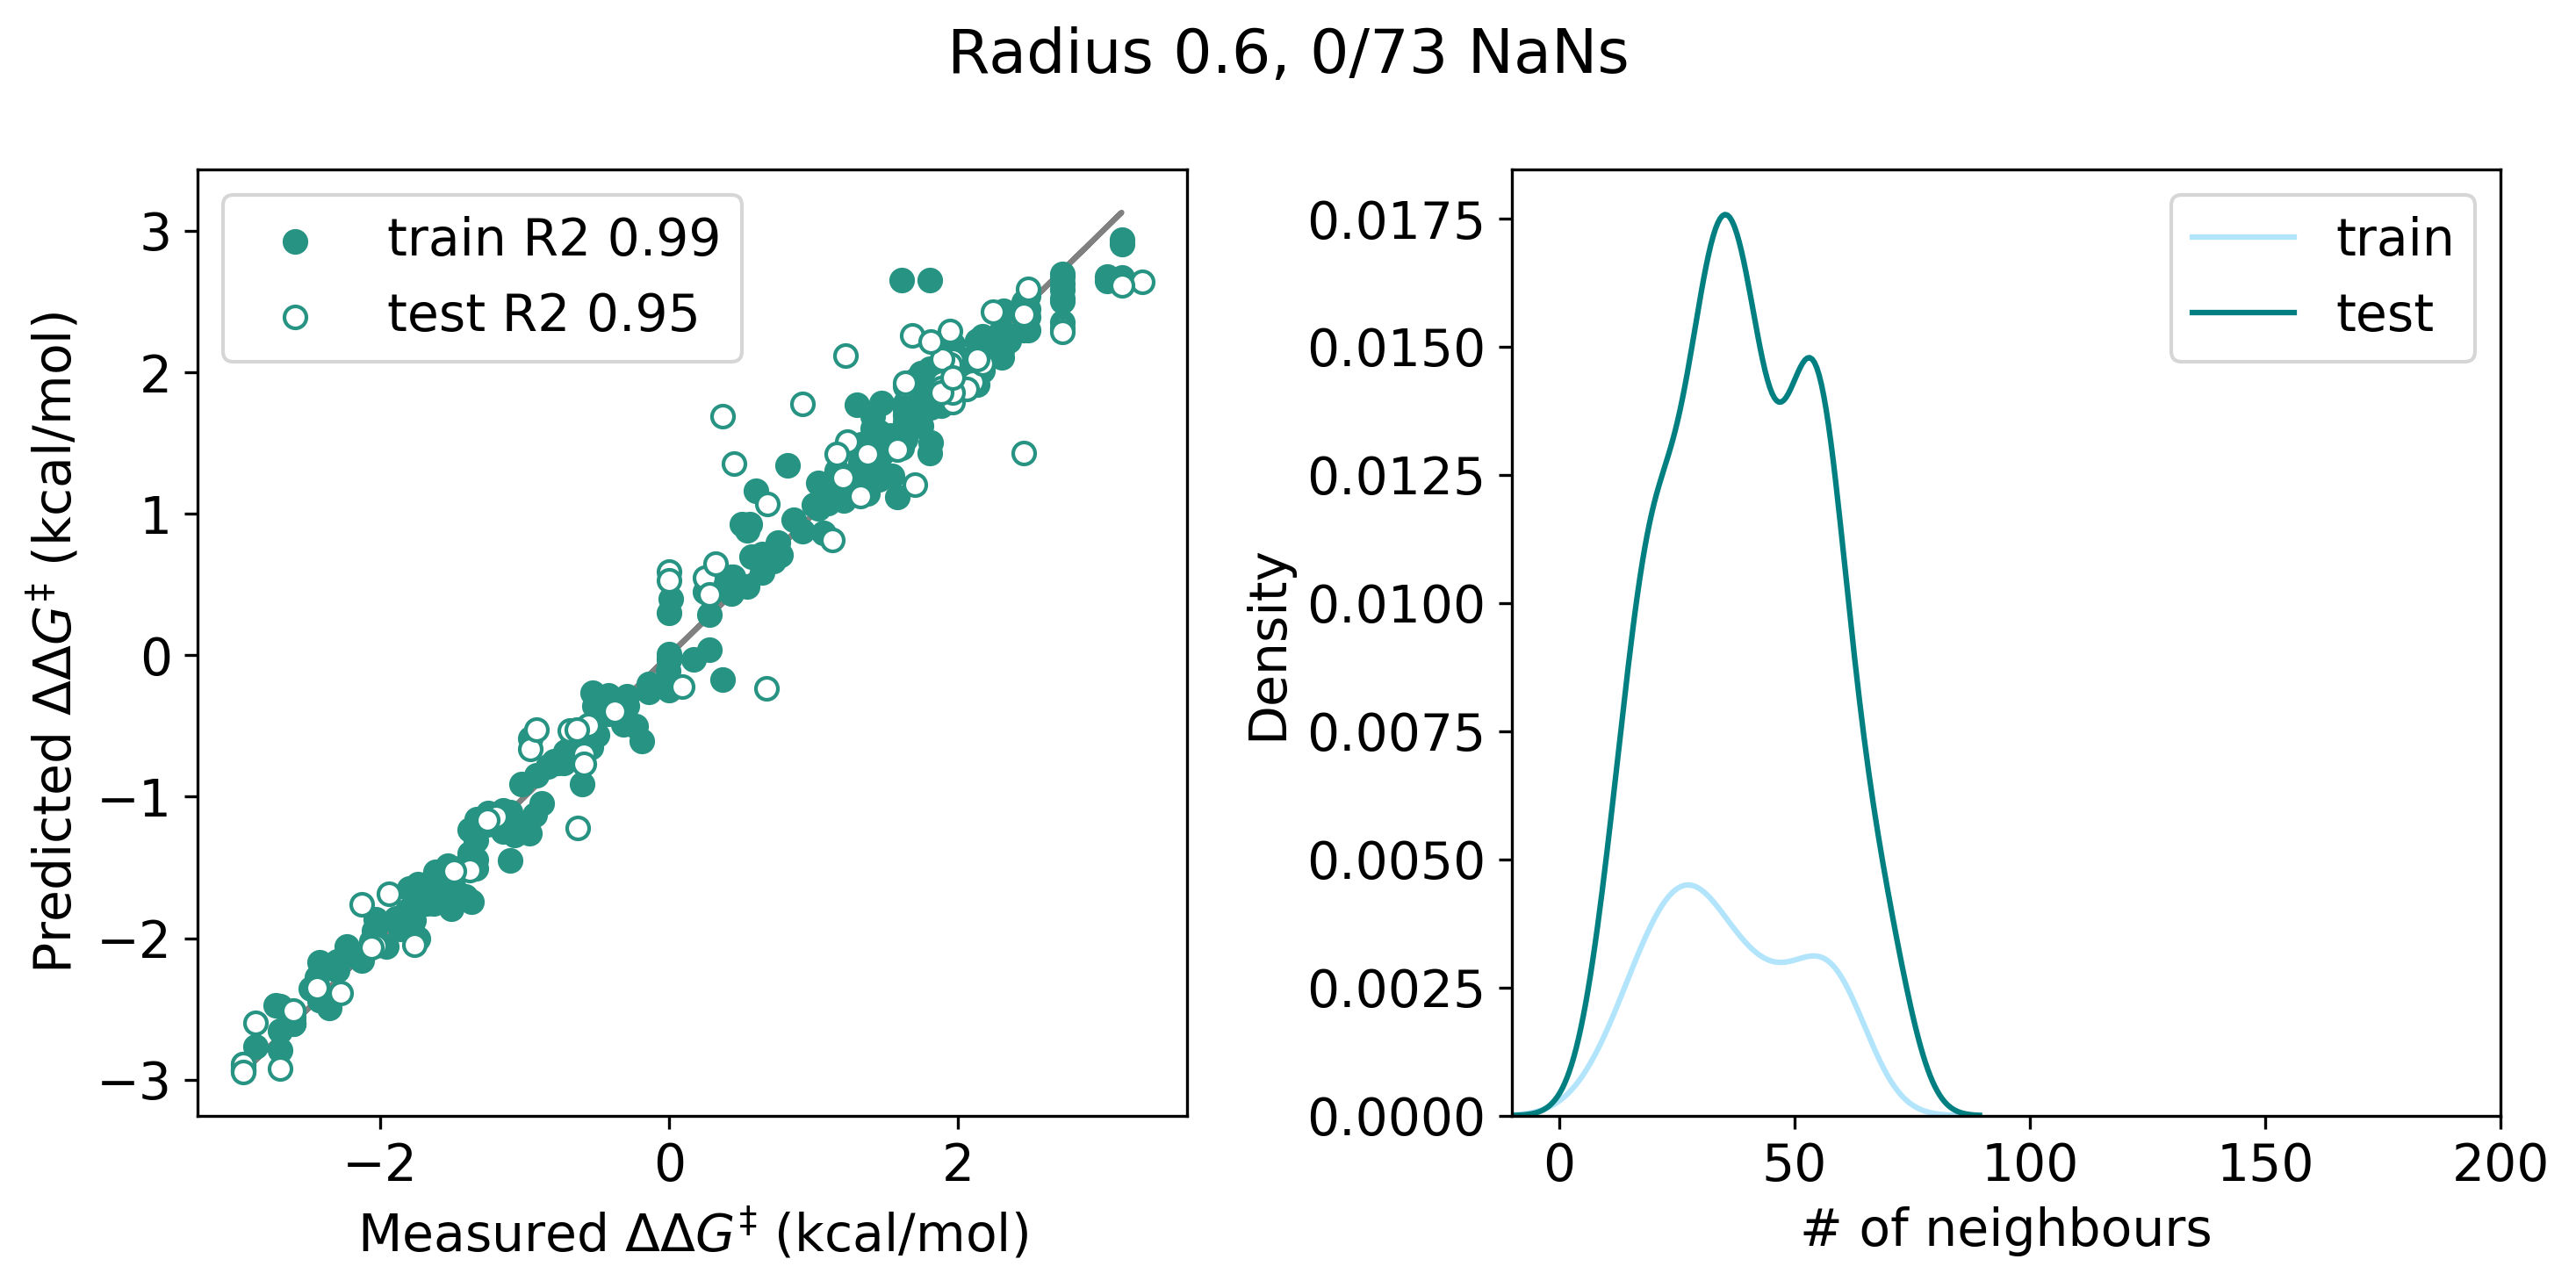

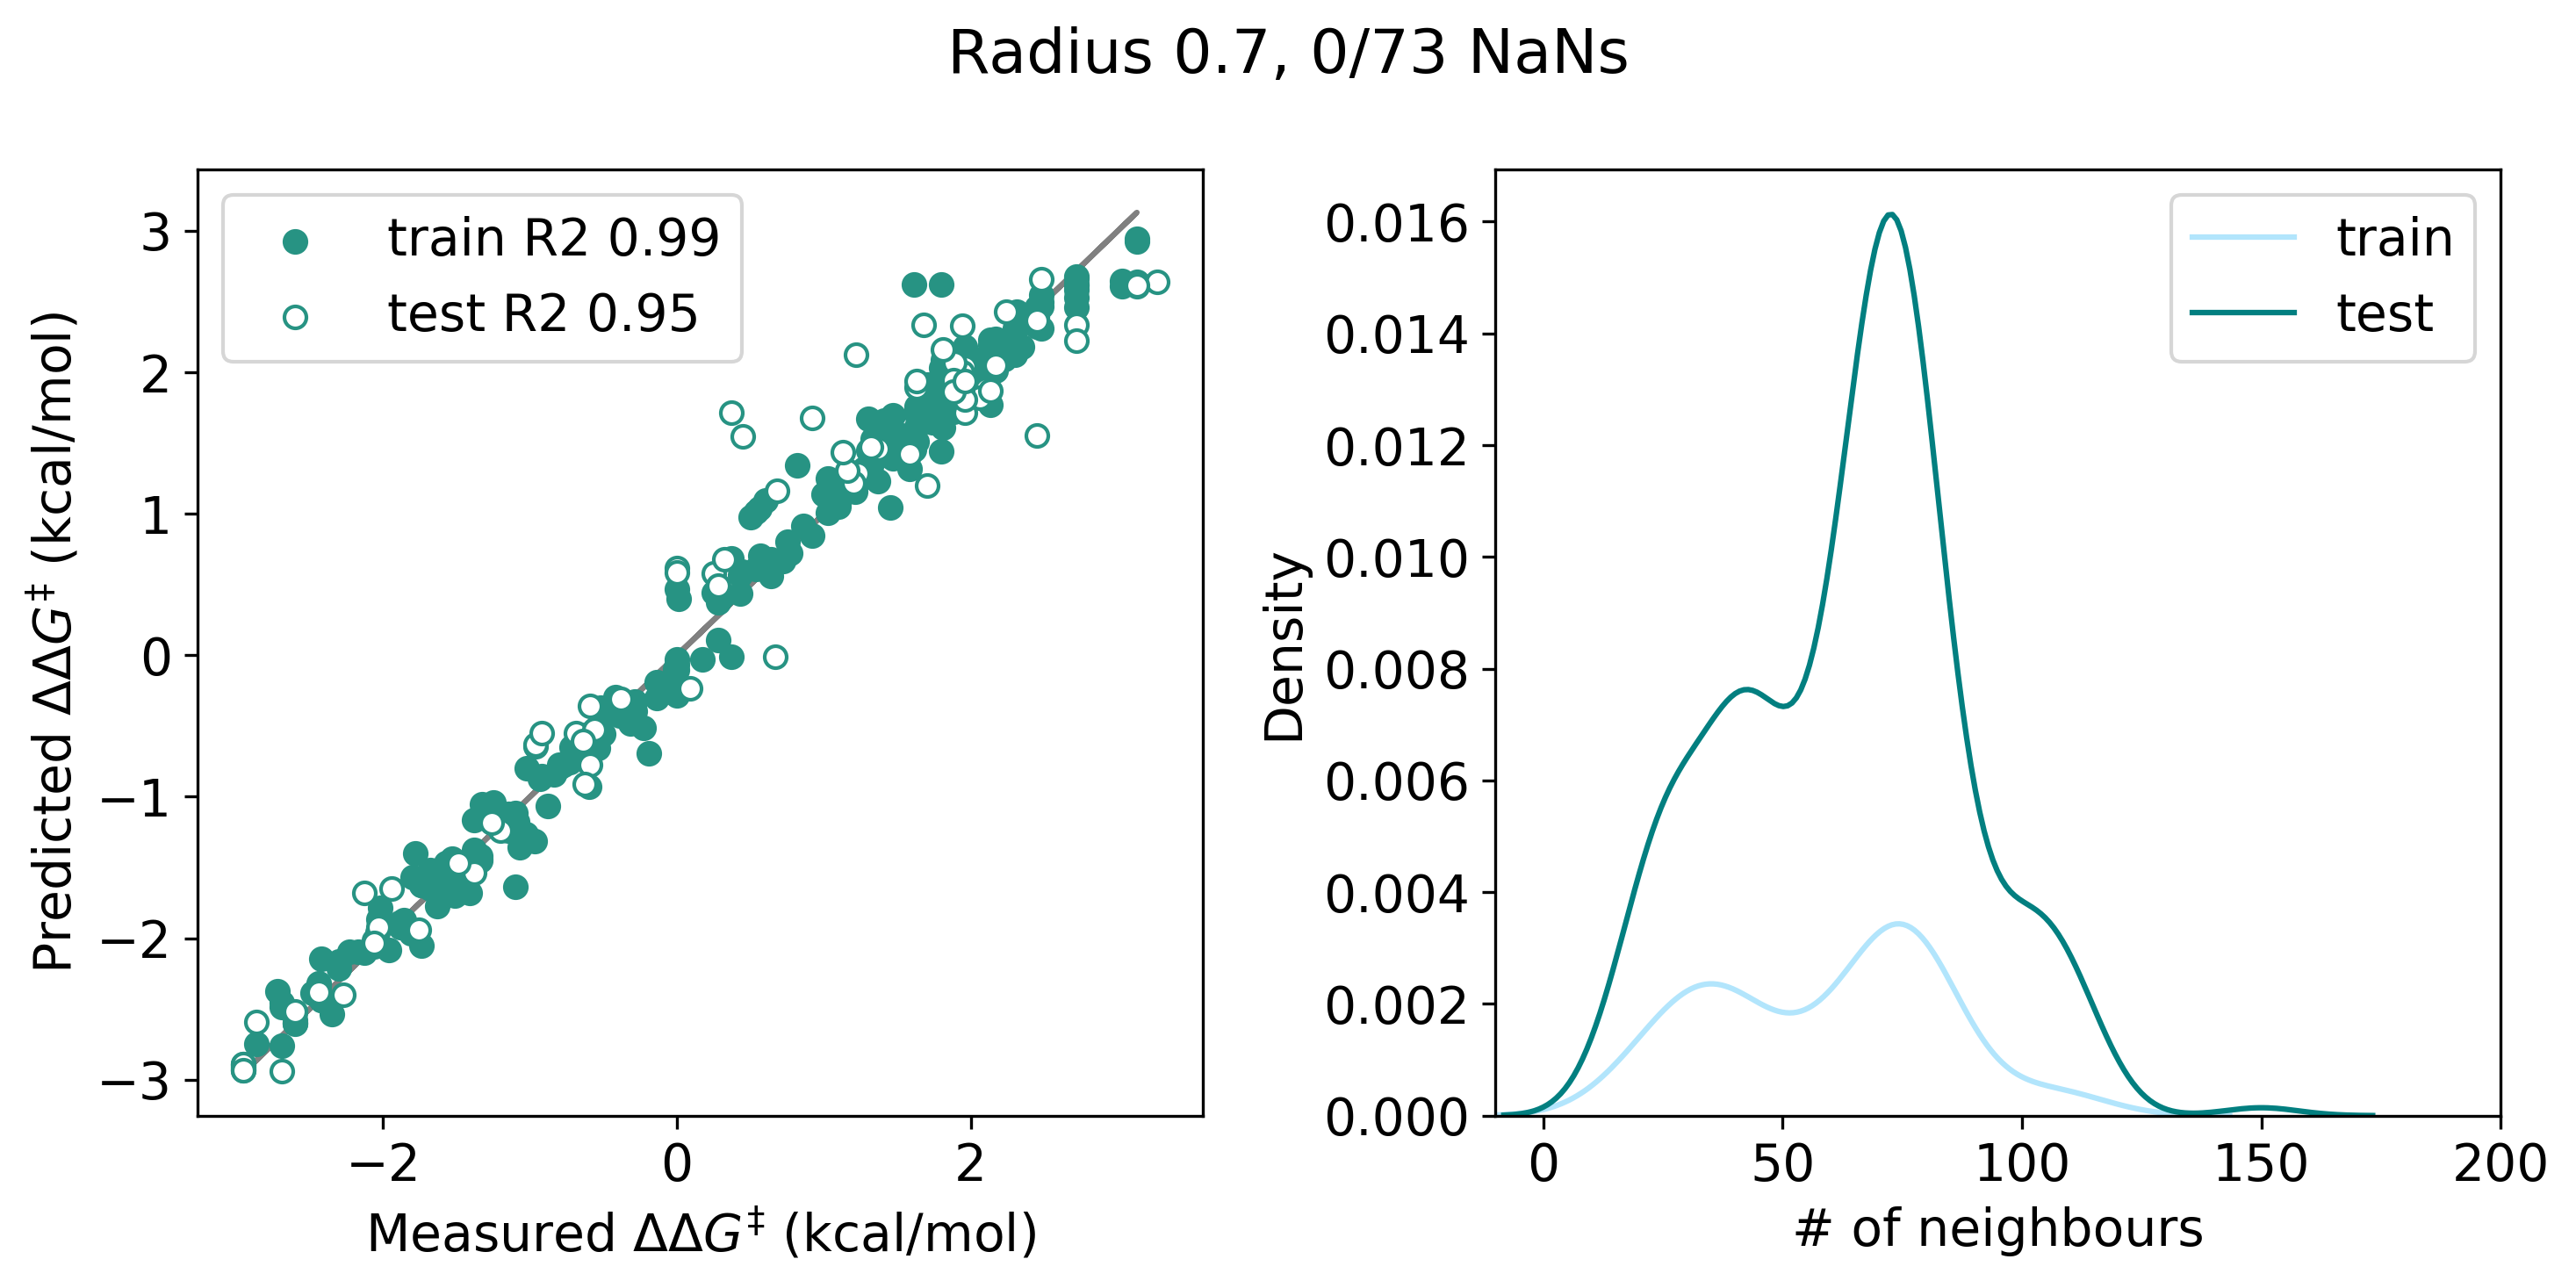

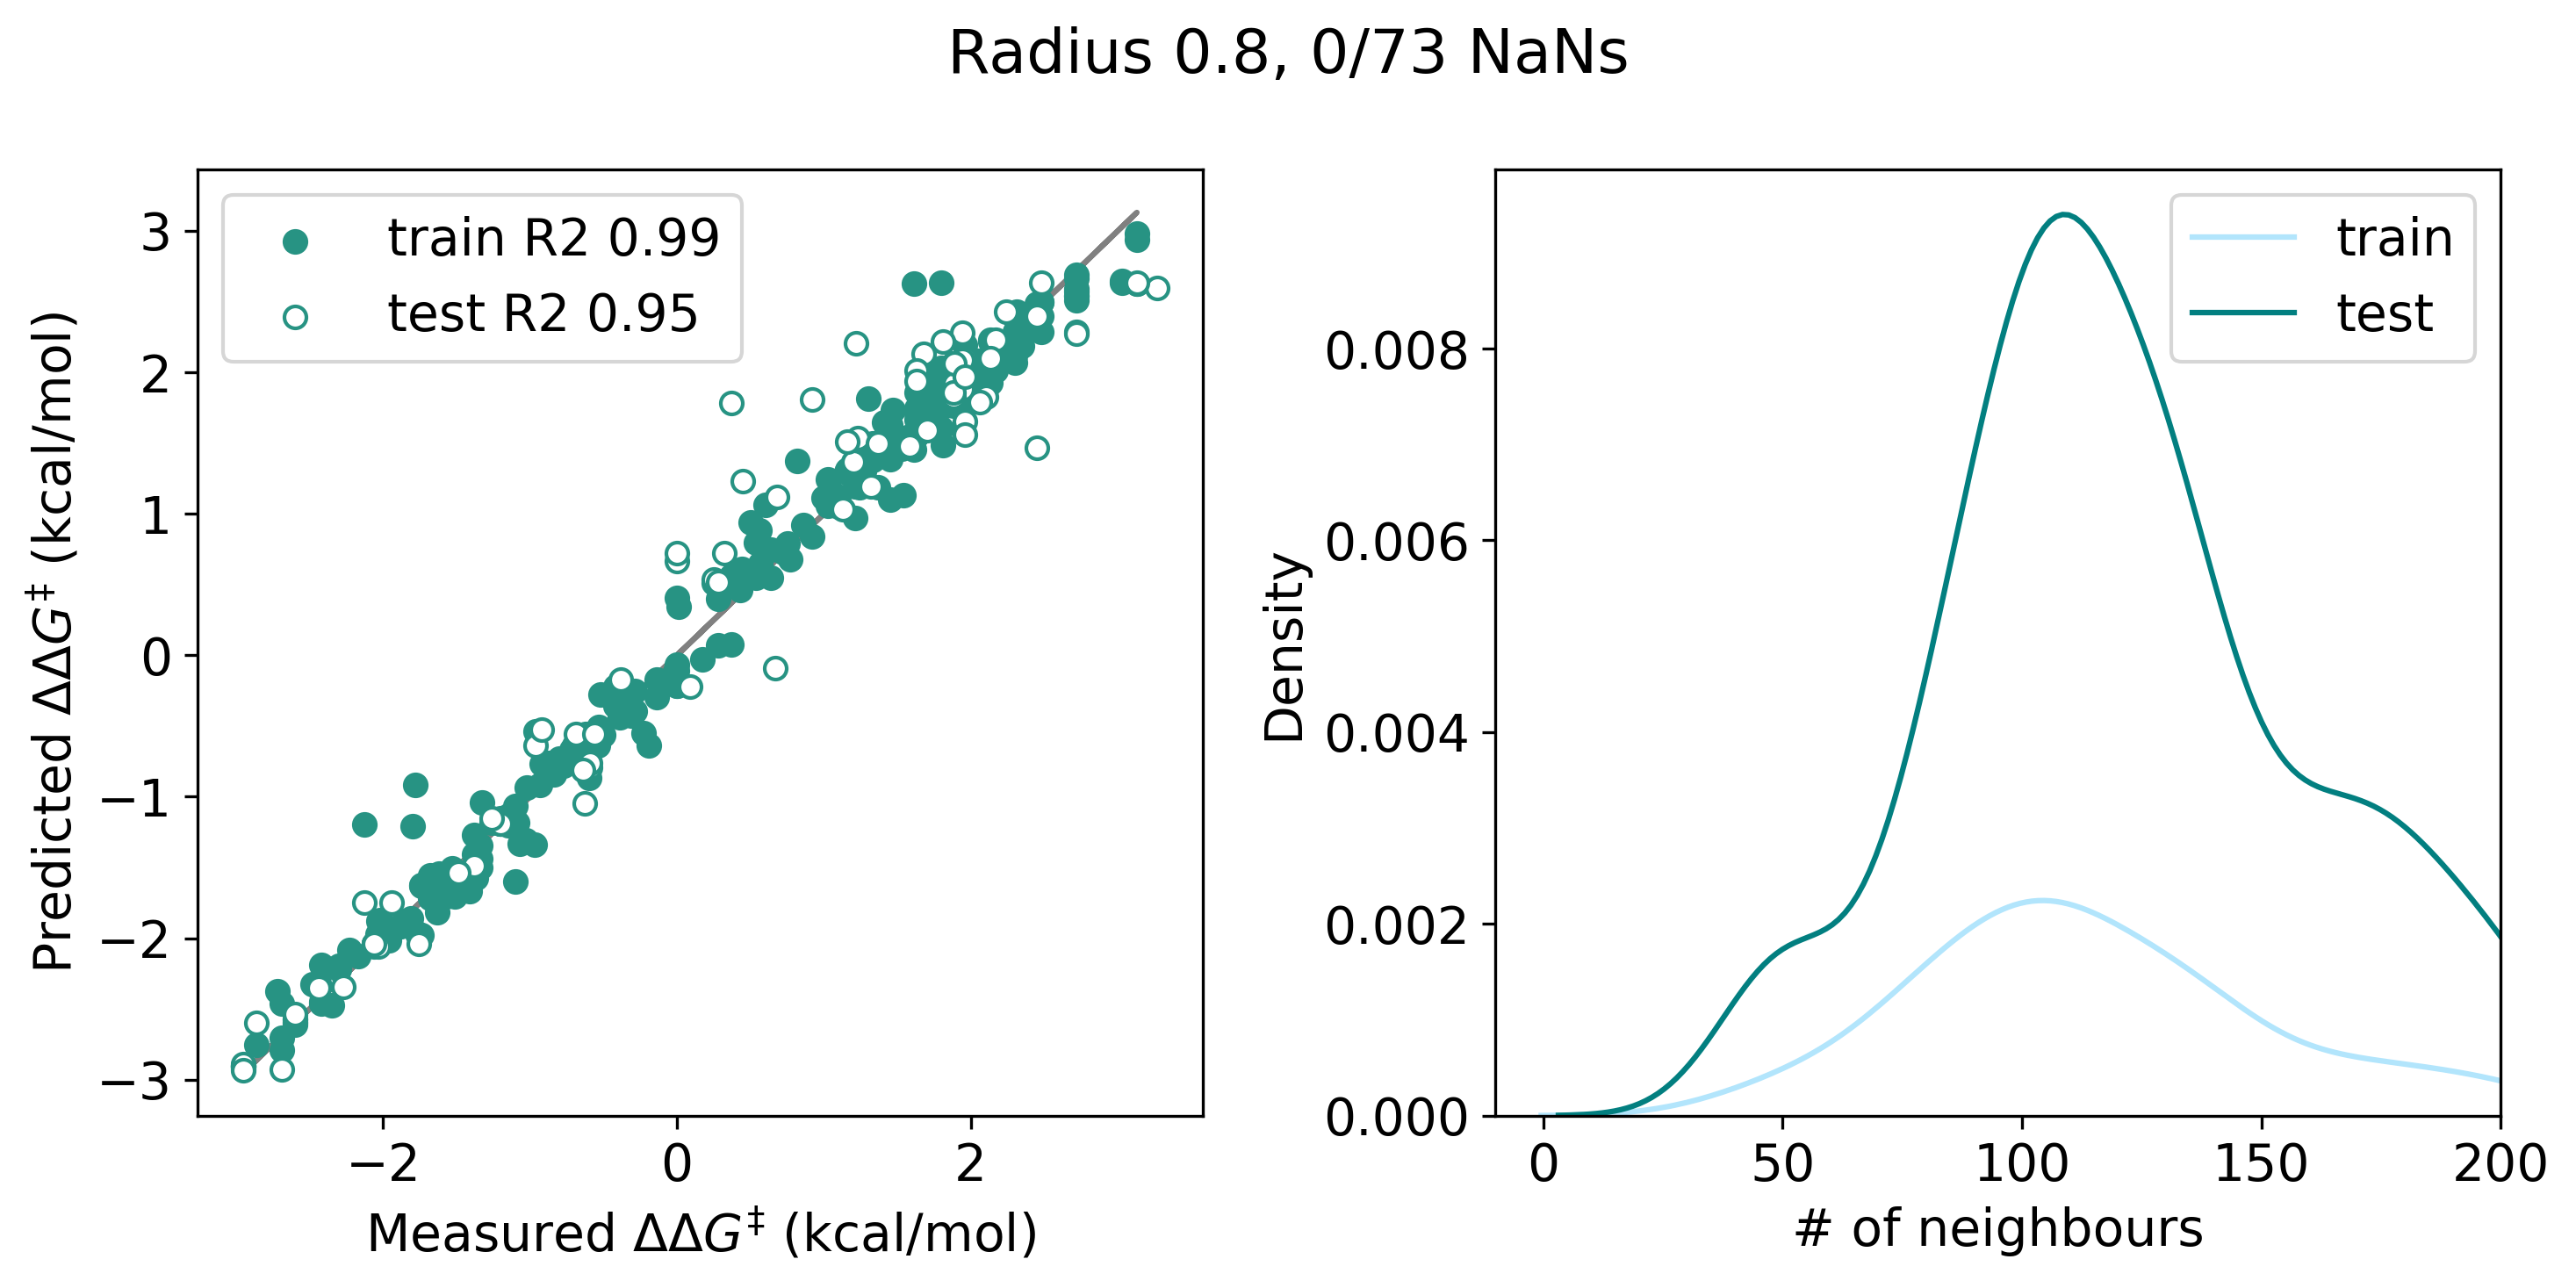

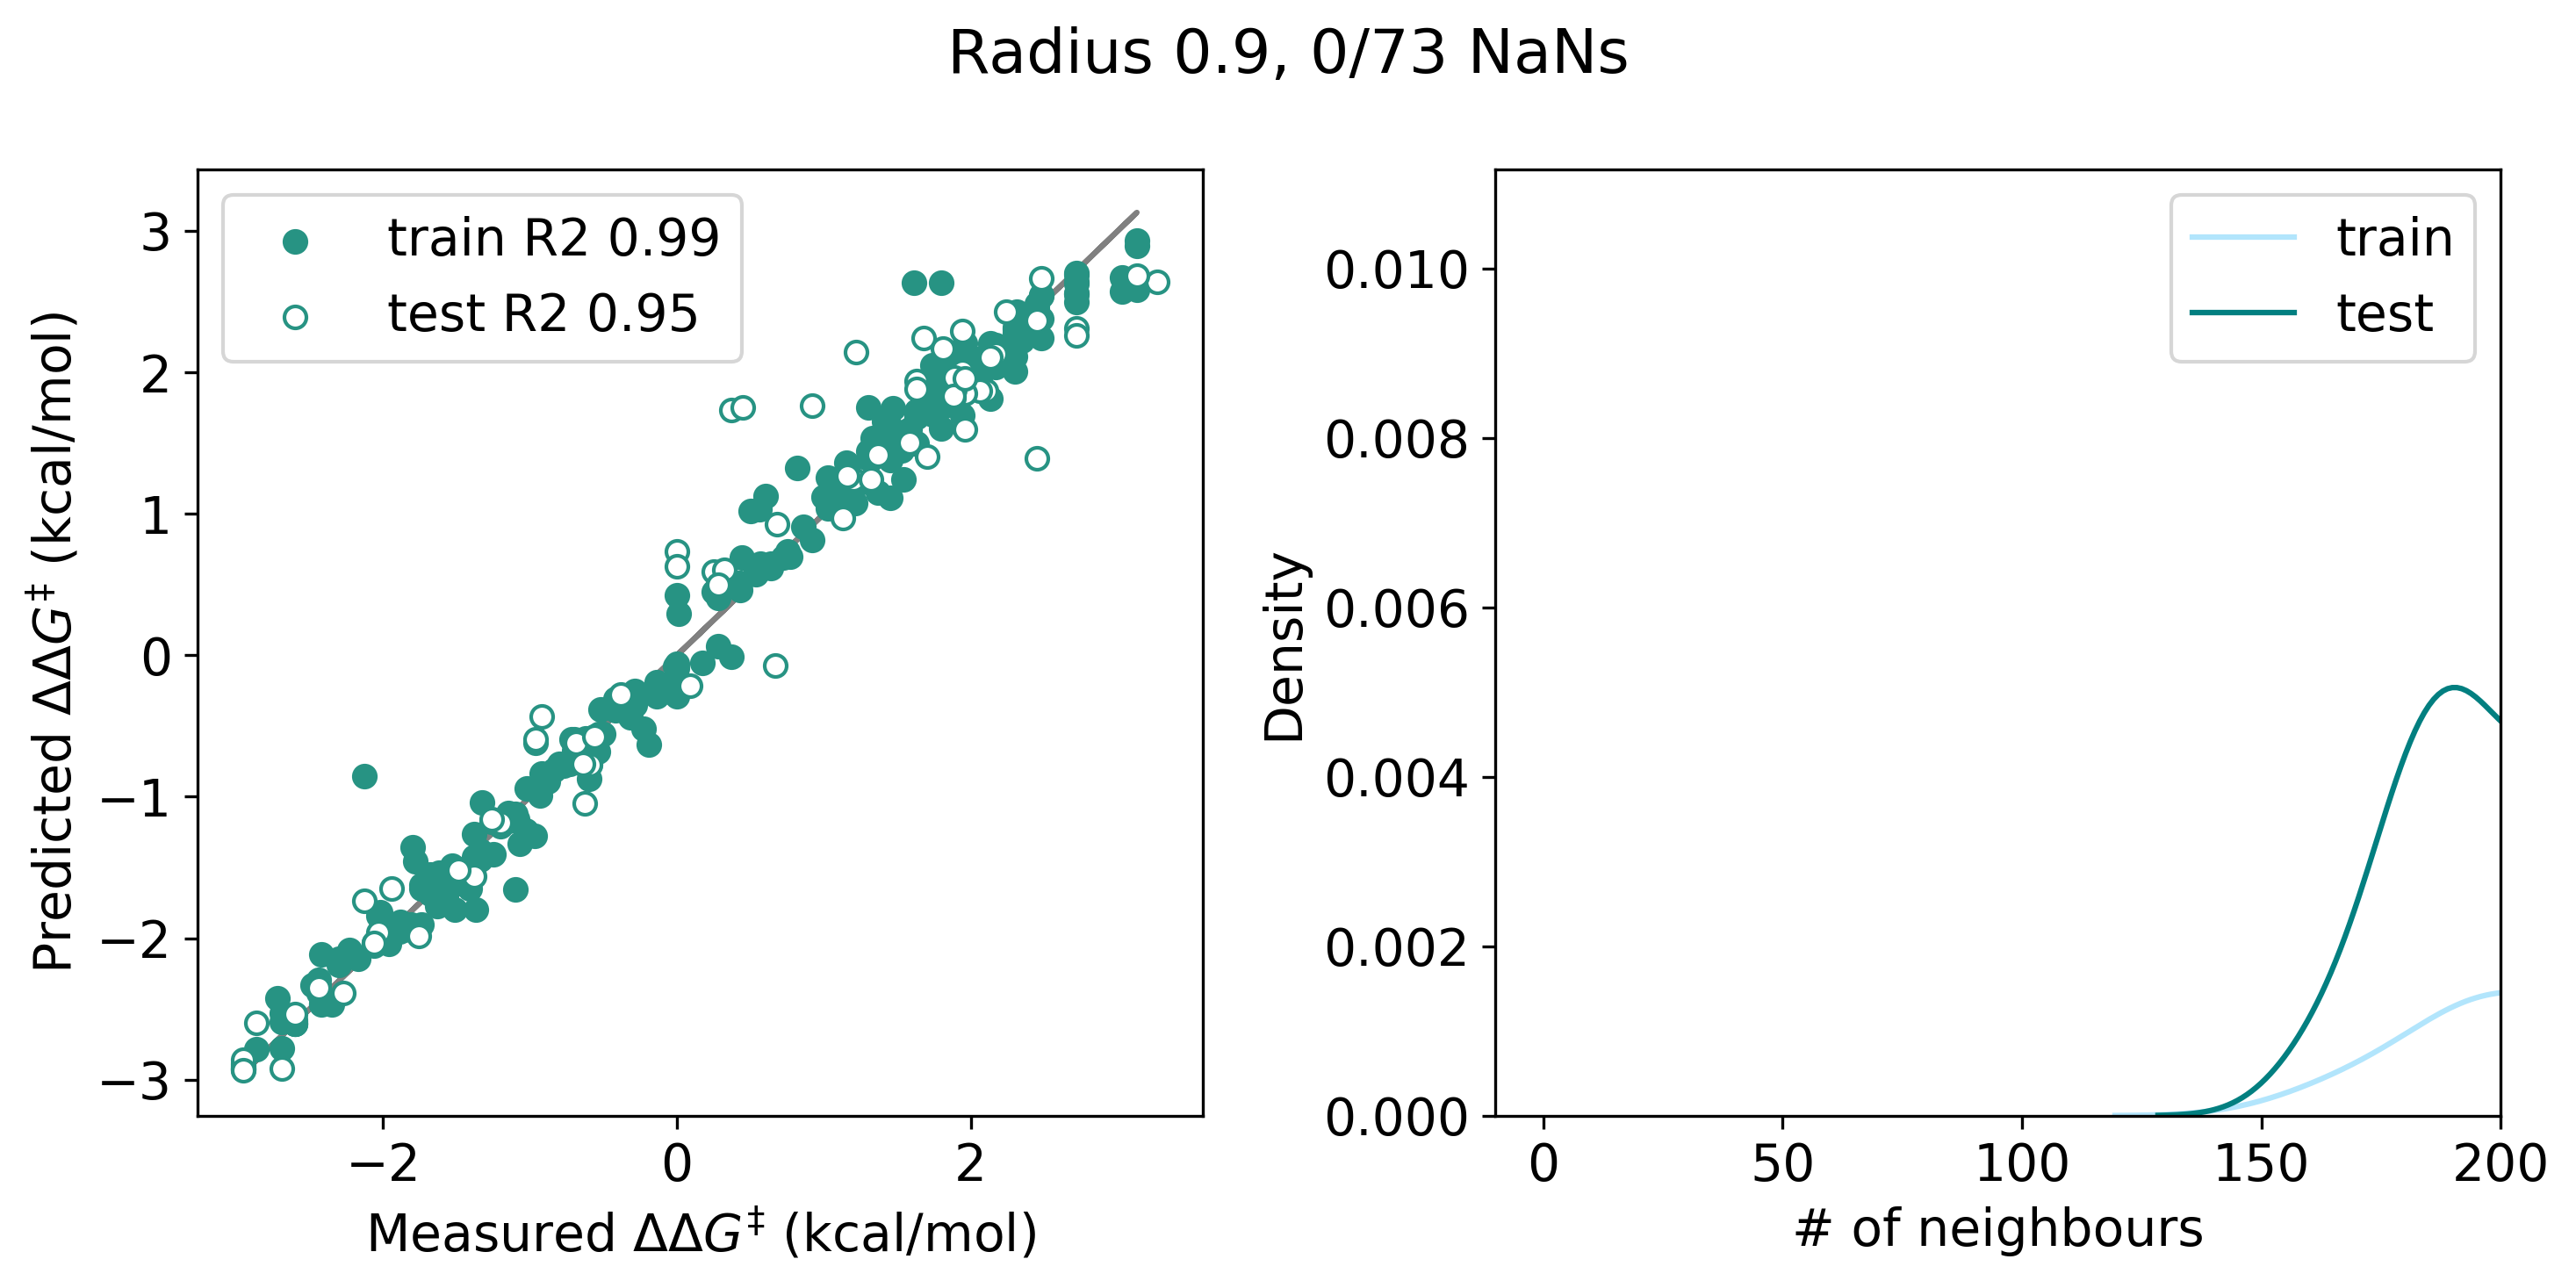

(0.2344174783549791, 0.23483825907888456, 0.24723817785389243, 0.2685181506849319, 0.26918651292771184, 0.2725563441505225, 0.2759876191236468, 0.282199554631509, 0.2682995713380991)
(51, 13, 3, 0, 0, 0, 0, 0, 0)
(2.772727272727273, 5.416666666666667, 9.685714285714285, 15.164383561643836, 21.684931506849313, 36.38356164383562, 59.41095890410959, 114.84931506849315, 233.08219178082192)
({-0.19, 1.61, 2.72, 3.13, 3.03, 1.8, -0.96, -0.73, 1.89, 2.17, 1.74, 2.31, -2.06, -1.15, 0.77, 0.44, -0.8, 1.03, -2.95, -1.88, 1.88, 1.54, 1.96, 2.45, -2.6, -2.86, -0.77, -1.26, -1.09, -2.42, -0.42, -2.72, -1.86}, {-0.5, 1.96, 2.48, 3.03, 3.13, 1.88, 2.72, 1.61, 1.8, 2.3, 1.63, 1.0, -0.01, -0.96, 1.54, 2.04, -1.53, 0.72, -2.03, -2.35, -2.6, -1.1, -2.17, -2.42, 0.44, 1.33, -1.74, -1.81, -0.56, 1.94, -2.95, -1.63, -1.88, -1.38, 0.17, 1.37, -1.2, -0.7, -2.02, 1.3, -0.52, -0.77, 2.23, -1.09, -1.34, 1.41, -0.92, -0.59, -0.84, -0.14, 0.64, -0.67, -0.73, 0.77, -0.8, 1.45, -2.3, 1.7, -1.62, 2.45, 2.13, -2.44, -

In [4]:
distances = utils.get_distances(X_train,X_test)


# need X_train, y_train, X_test, y_test, distances
results = []

for radius in np.divide(range(1,10),10):
    results.append(run_and_plot(radius, X_train, y_train, X_test, y_test, distances))

RaRF_mae, nans, avg_neighbours, all_reactions, test_r2s = zip(*results)

print(RaRF_mae)
print(nans)
print(avg_neighbours)
print(all_reactions)
print([len(ar) for ar in all_reactions])
print(test_r2s)

In [6]:
# Wait. Why are those the same? Are they all the same reactions? They must be, right?
# Probably, Double check. Then, save some work.
# Then, just do aquisitions.
# But the R2's are a little different. And so are the MAEs. I hope it's not some shenanigs.
# Okay, I need to set an sklearn seed.
# Look at random state. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
RaRF_mae

(0.2344174783549791,
 0.23483825907888456,
 0.24723817785389243,
 0.2685181506849319,
 0.26918651292771184,
 0.2725563441505225,
 0.2759876191236468,
 0.282199554631509,
 0.2682995713380991)